<a href="https://colab.research.google.com/github/UdaySMukherjee/DeepLearning-Assignment-3rd-Year/blob/main/CiamVid_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, size, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=size)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, size=(8,8), batch=16):
    out = torchvision.utils.make_grid(inputs[:batch])
    imshow(out, size)

def Color_map(dataframe):

  cls = pd.read_csv(dataframe)
  color_code = [tuple(cls.drop("name",axis=1).loc[idx]) for idx in range(len(cls.name))]
  code2id = {v: k for k, v in enumerate(list(color_code))}
  id2code = {k: v for k, v in enumerate(list(color_code))}

  color_name = [cls['name'][idx] for idx in range(len(cls.name))]
  name2id = {v: k for k, v in enumerate(list(color_name))}
  id2name = {k: v for k, v in enumerate(list(color_name))}
  return code2id, id2code, name2id, id2name

def rgb_to_mask(img, color_map):

    num_classes = len(color_map)
    shape = img.shape[:2]+(num_classes,)
    out = np.zeros(shape, dtype=np.float64)
    for i, cls in enumerate(color_map):
        out[:,:,i] = np.all(np.array(img).reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])
    return out.transpose(2,0,1)

def mask_to_rgb(mask, color_map):

    single_layer = np.argmax(mask, axis=1)
    output = np.zeros((mask.shape[0],mask.shape[2],mask.shape[3],3))
    for k in color_map.keys():
        output[single_layer==k] = color_map[k]
    return np.uint8(output)

def plotCurves(stats):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and Validation Loss Curve')
    plt.show()

def Visualize(imgs, title='Original', cols=6, rows=1, plot_size=(16, 16), change_dim=False):
    fig=plt.figure(figsize=plot_size)
    columns = cols
    rows = rows
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.title(title+str(i))
        if change_dim: plt.imshow(imgs.transpose(0,2,3,1)[i])
        else: plt.imshow(imgs[i])
    plt.show()

eval

In [58]:
import torch
import torch.nn as nn
import numpy as np



def Validate(model, validloader, criterion, valid_loss_min, device, model_path):
    valid_loss = 0
    val_iou = []
    val_losses = []
    model.eval()
    for i, val_data in enumerate(validloader):
        inp, masks, _ = val_data
        inp, masks = inp.to(device), masks.to(device)
        out = model(inp)
        val_target = masks.argmax(1)
        val_loss = criterion(out, val_target.long())
        valid_loss += val_loss.item() * inp.size(0)
        iou = iou_pytorch(out.argmax(1), val_target)
        val_iou.extend(iou)
    miou = torch.FloatTensor(val_iou).mean()
    valid_loss = valid_loss / len(validloader.dataset)
    val_losses.append(valid_loss)
    print(f'\t\t Validation Loss: {valid_loss:.4f},',f' Validation IoU: {miou:.3f}')

    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), model_path+'/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,np.mean(val_losses))+'\n')
        valid_loss_min = np.mean(val_losses)

    return valid_loss, valid_loss_min

def Test_eval(model, testloader, criterion, model_save_pth, device):
      model.load_state_dict(torch.load(model_save_pth))
      model.eval()
      test_loss = 0
      imgs, masks, preds = [], [], []
      for i, test_data in enumerate(testloader):
        img, mask = test_data
        inp, mask = img.to(device), mask.to(device)
        imgs.extend(inp.cpu().numpy())
        masks.extend(mask.cpu().numpy())
        out = model(inp.float())
        preds.extend(out.detach().cpu().numpy())
        target = mask.argmax(1)
        loss = criterion(out, target.long())
        test_loss += loss.item() * inp.size(0)
      test_loss = loss / len(testloader.dataset)
      pred = mask_to_rgb(np.array(preds), CONFIG.id2code)
      print(f"Test loss is: {test_loss:.4f}")
      return np.array(imgs), np.array(masks), np.array(pred)

Iou

In [59]:
import torch

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    #outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

model

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

CamVid

In [48]:
import natsort
import os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image


class CamVid_Dataset():
  def __init__(self, img_pth, mask_pth, transform):
    self.img_pth = img_pth
    self.mask_pth = mask_pth
    self.transform = transform
    all_imgs = os.listdir(self.img_pth)
    all_masks = [img_name[:-4] + '_L' + img_name[-4:] for img_name in all_imgs]
    self.total_imgs = natsort.natsorted(all_imgs)
    self.total_masks = natsort.natsorted(all_masks)

  def __len__(self):
    return len(self.total_imgs)

  def __getitem__(self, idx):
    img_loc = os.path.join(self.img_pth, self.total_imgs[idx])
    image = Image.open(img_loc).convert("RGB")
    mask_loc = os.path.join(self.mask_pth, self.total_masks[idx])
    mask = Image.open(mask_loc).convert("RGB")
    out_image, rgb_mask = self.transform(image), self.transform(mask)
    out_image = transforms.Compose([transforms.ToTensor()])(out_image)
    rgb_mask = transforms.Compose([transforms.PILToTensor()])(rgb_mask)
    out_mask = rgb_to_mask(torch.from_numpy(np.array(rgb_mask)).permute(1,2,0), id2code)

    return out_image, out_mask, rgb_mask.permute(0,1,2)

class Test():
  def __init__(self, img_pth, mask_pth, transform):
    self.img_pth = img_pth
    self.mask_pth = mask_pth
    self.transform = transform
    all_imgs = os.listdir(self.img_pth)
    all_masks = [img_name[:-4] + '_L' + img_name[-4:] for img_name in all_imgs]
    self.total_imgs = natsort.natsorted(all_imgs)
    self.total_masks = natsort.natsorted(all_masks)

  def __len__(self):
    return len(self.total_imgs)

  def __getitem__(self, idx):
    img_loc = os.path.join(self.img_pth, self.total_imgs[idx])
    image = Image.open(img_loc).convert("RGB")
    out_image = self.transform(image)

    mask_loc = os.path.join(self.mask_pth, self.total_masks[idx])
    mask = Image.open(mask_loc).convert("RGB")
    rgb_mask = self.transform(mask)

    return out_image, rgb_mask

loss

In [49]:
import torch
import torch.nn as nn

ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):

        #first compute binary cross-entropy
        BCE = nn.CrossEntropyLoss()(inputs, targets)
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE

        return focal_loss

Config

In [53]:
import torch
import os
from torch import cuda
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class config(object):

  model_path = "/content/drive/MyDrive/dataset/archive/models/"
  path = "/content/drive/MyDrive/dataset/archive/CamVid/"

  batch = 4
  lr = 0.0001
  epochs = 40
  input_size = (128,128)
  if cuda.is_available(): device = torch.device("cuda")
  else: device = torch.device('cpu')
  code2id, id2code, name2id, id2name = Color_map(path+'class_dict.csv')

train

The device being used is: cuda

Training Started.....
The training images


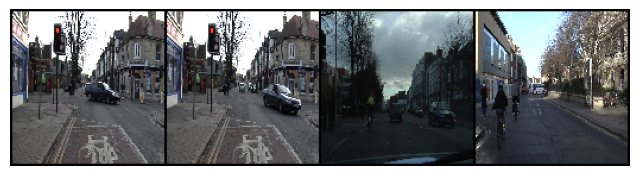

The original masks


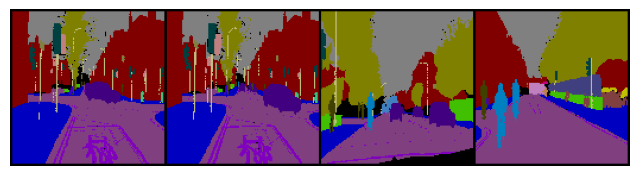

Predicted masks


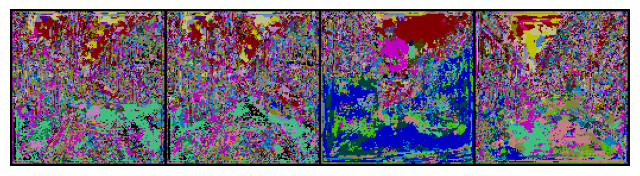

Epoch 0 : Lr (0.0001) 
		 Training Loss: 1.8189,  Training IoU: 0.183,
		 Validation Loss: 0.9954,  Validation IoU: 0.329
Validation loss decreased (inf --> 0.995402). Saving model ...

Epoch 1 : Lr (0.0001) 
		 Training Loss: 0.6405,  Training IoU: 0.318,
		 Validation Loss: 0.5067,  Validation IoU: 0.338
Validation loss decreased (0.995402 --> 0.506721). Saving model ...

Epoch 2 : Lr (0.0001) 
		 Training Loss: 0.4186,  Training IoU: 0.422,
		 Validation Loss: 0.3606,  Validation IoU: 0.484
Validation loss decreased (0.506721 --> 0.360631). Saving model ...

Epoch 3 : Lr (0.0001) 
		 Training Loss: 0.3284,  Training IoU: 0.495,
		 Validation Loss: 0.2987,  Validation IoU: 0.514
Validation loss decreased (0.360631 --> 0.298696). Saving model ...

Epoch 4 : Lr (0.0001) 
		 Training Loss: 0.2496,  Training IoU: 0.549,
		 Validation Loss: 0.2494,  Validation IoU: 0.575
Validation loss decreased (0.298696 --> 0.249364). Saving model ...

Epoch 5 : Lr (0.0001) 
		 Training Loss: 0.2108,  

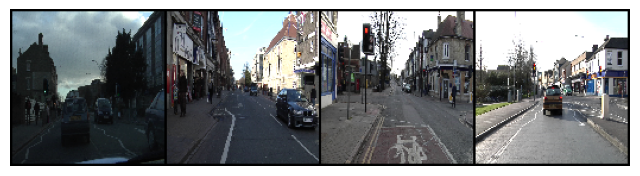

The original masks


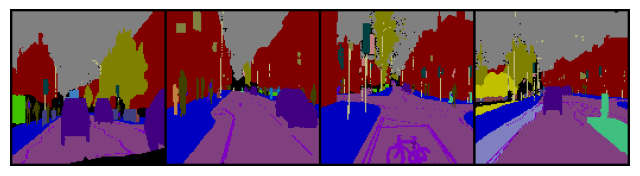

Predicted masks


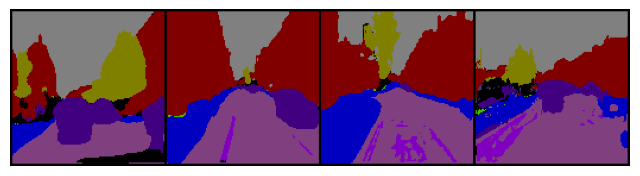

Epoch 10 : Lr (0.0001) 
		 Training Loss: 0.1149,  Training IoU: 0.681,
		 Validation Loss: 0.1411,  Validation IoU: 0.668
Validation loss decreased (0.145423 --> 0.141126). Saving model ...

Epoch 11 : Lr (0.0001) 
		 Training Loss: 0.1087,  Training IoU: 0.684,
		 Validation Loss: 0.1274,  Validation IoU: 0.688
Validation loss decreased (0.141126 --> 0.127375). Saving model ...

Epoch 12 : Lr (0.0001) 
		 Training Loss: 0.0983,  Training IoU: 0.700,
		 Validation Loss: 0.1318,  Validation IoU: 0.695
Epoch 13 : Lr (0.0001) 
		 Training Loss: 0.0877,  Training IoU: 0.717,
		 Validation Loss: 0.1296,  Validation IoU: 0.694
Epoch 14 : Lr (0.0001) 
		 Training Loss: 0.0784,  Training IoU: 0.728,
		 Validation Loss: 0.1133,  Validation IoU: 0.712
Validation loss decreased (0.127375 --> 0.113346). Saving model ...

Epoch 15 : Lr (0.0001) 
		 Training Loss: 0.0708,  Training IoU: 0.741,
		 Validation Loss: 0.1095,  Validation IoU: 0.704
Validation loss decreased (0.113346 --> 0.109510). Savi

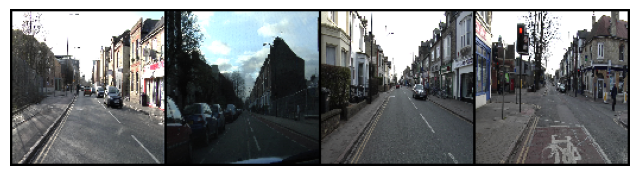

The original masks


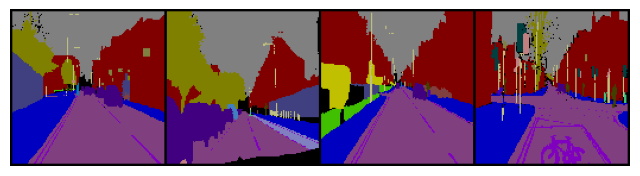

Predicted masks


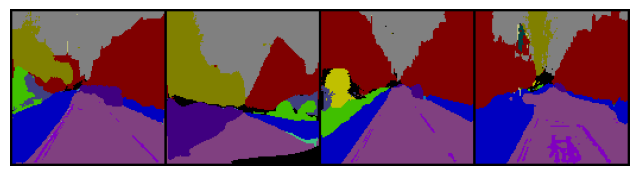

Epoch 20 : Lr (0.0001) 
		 Training Loss: 0.0493,  Training IoU: 0.779,
		 Validation Loss: 0.0935,  Validation IoU: 0.737
Validation loss decreased (0.099158 --> 0.093472). Saving model ...

Epoch 21 : Lr (0.0001) 
		 Training Loss: 0.0445,  Training IoU: 0.792,
		 Validation Loss: 0.0915,  Validation IoU: 0.752
Validation loss decreased (0.093472 --> 0.091505). Saving model ...

Epoch 22 : Lr (0.0001) 
		 Training Loss: 0.0413,  Training IoU: 0.798,
		 Validation Loss: 0.0952,  Validation IoU: 0.751
Epoch 23 : Lr (0.0001) 
		 Training Loss: 0.0377,  Training IoU: 0.807,
		 Validation Loss: 0.0874,  Validation IoU: 0.756
Validation loss decreased (0.091505 --> 0.087445). Saving model ...

Epoch 24 : Lr (0.0001) 
		 Training Loss: 0.0357,  Training IoU: 0.809,
		 Validation Loss: 0.0925,  Validation IoU: 0.744
Epoch 25 : Lr (0.0001) 
		 Training Loss: 0.0327,  Training IoU: 0.815,
		 Validation Loss: 0.0917,  Validation IoU: 0.758
Epoch 26 : Lr (0.0001) 
		 Training Loss: 0.0300,  Trai

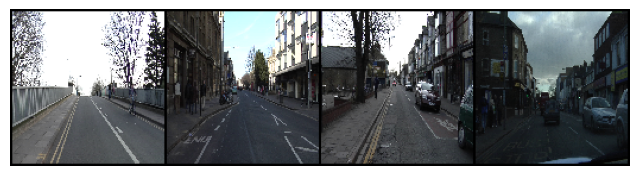

The original masks


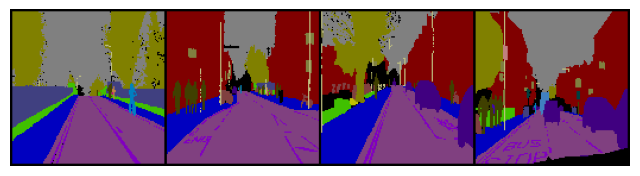

Predicted masks


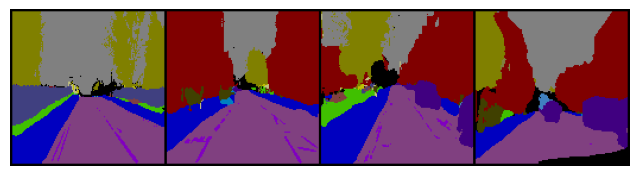

Epoch 30 : Lr (0.0001) 
		 Training Loss: 0.0233,  Training IoU: 0.840,
		 Validation Loss: 0.0907,  Validation IoU: 0.764
Epoch 31 : Lr (0.0001) 
		 Training Loss: 0.0224,  Training IoU: 0.842,
		 Validation Loss: 0.0903,  Validation IoU: 0.768
Epoch 32 : Lr (0.0001) 
		 Training Loss: 0.0214,  Training IoU: 0.845,
		 Validation Loss: 0.0922,  Validation IoU: 0.760
Epoch 33 : Lr (0.0001) 
		 Training Loss: 0.0205,  Training IoU: 0.848,
		 Validation Loss: 0.0868,  Validation IoU: 0.764
Validation loss decreased (0.087445 --> 0.086840). Saving model ...

Epoch 34 : Lr (0.0001) 
		 Training Loss: 0.0195,  Training IoU: 0.852,
		 Validation Loss: 0.0850,  Validation IoU: 0.770
Validation loss decreased (0.086840 --> 0.084977). Saving model ...

Epoch 35 : Lr (0.0001) 
		 Training Loss: 0.0186,  Training IoU: 0.855,
		 Validation Loss: 0.0868,  Validation IoU: 0.767
Epoch 36 : Lr (0.0001) 
		 Training Loss: 0.0178,  Training IoU: 0.857,
		 Validation Loss: 0.0863,  Validation IoU: 0.768
E

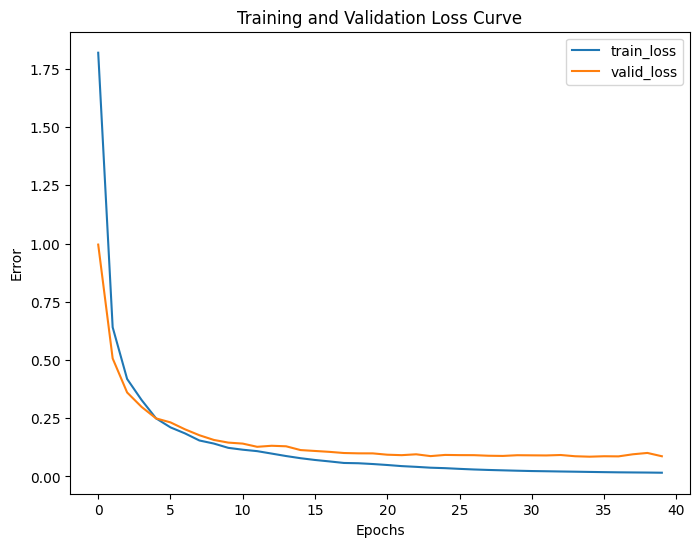

In [54]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms

CONFIG = config()

path = CONFIG.path
batch = CONFIG.batch
lr = CONFIG.lr
epochs = CONFIG.epochs
device = CONFIG.device
print(f"The device being used is: {device}\n")
id2code = CONFIG.id2code
input_size = CONFIG.input_size
model_sv_pth = CONFIG.model_path


def train(model, trainloader, validloader, criterion, optimizer, epochs, device, load_pth, model_sv_pth, plot=True, visualize=False, load_model=False):
    if load_model: model.load_state_dict(torch.load(load_pth))
    model.train()
    stats = []
    valid_loss_min = np.Inf
    print('Training Started.....')
    for epoch in range(epochs):
        train_loss = 0
        train_iou = []
        for i, data in enumerate(trainloader):
            inputs, mask, rgb = data
            inputs, mask = inputs.to(device), mask.to(device)
            optimizer.zero_grad()
            output = model(inputs.float())
            target = mask.argmax(1)
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            iou = iou_pytorch(output.argmax(1), target)
            train_iou.extend(iou)
            if visualize and epoch%10==0 and i == 0:
                print('The training images')
                show_databatch(inputs.detach().cpu(), size=(8,8))
                print('The original masks')
                show_databatch(rgb.detach().cpu(), size=(8,8))
                RGB_mask =  mask_to_rgb(output.detach().cpu(), id2code)
                print('Predicted masks')
                show_databatch(torch.tensor(RGB_mask).permute(0,3,1,2), size=(8,8))
        miou = torch.FloatTensor(train_iou).mean()
        train_loss = train_loss / len(trainloader.dataset)
        print('Epoch',epoch,':',f'Lr ({optimizer.param_groups[0]["lr"]})',f'\n\t\t Training Loss: {train_loss:.4f},',f' Training IoU: {miou:.3f},')

        with torch.no_grad():
            valid_loss, valid_loss_min = Validate(model, validloader, criterion, valid_loss_min, device, model_sv_pth)

        stats.append([train_loss, valid_loss])
        stat = pd.DataFrame(stats, columns=['train_loss', 'valid_loss'])

    print('Finished Training')
    if plot: plotCurves(stat)


if __name__ == "__main__":

    #Define transforms for the training data and validation data
    train_transforms = transforms.Compose([transforms.Resize(input_size, 0)])
    valid_transforms = transforms.Compose([transforms.Resize(input_size, 0)])

    #pass transform here-in
    train_data = CamVid_Dataset(img_pth = path + 'train/', mask_pth = path + 'train_labels/', transform = train_transforms)
    valid_data = CamVid_Dataset(img_pth = path + 'val/', mask_pth = path + 'val_labels/', transform = valid_transforms)

    #data loaders
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch, shuffle=True)

    model = UNet(3, 32, True).to(device)
    criterion = FocalLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)

    train(model, trainloader, validloader, criterion, optimizer, epochs, device, model_sv_pth, plot=True, visualize=True, load_model=False)